In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import numpy as np

In [10]:
#Functions for data processing
def clean(raw):
    #Selecting subset of interest
    df = raw[["Area","Variable Name","Year","Value"]].drop_duplicates()
    #Creating wide(r) version with one column per variable
    cleaned = df.set_index(["Area","Variable Name","Year"]).unstack("Variable Name").droplevel(0,axis=1).reset_index()
    #Shortening the somewhat unwieldy variable names
    cleaned.columns = ["Area","Year","GDP per capita","Human Development Index", "Water withdrawal per capita"]
    #Excluding rows that don't have any information about Water withdrawal per capita
    filtered = cleaned.dropna(subset=["Water withdrawal per capita"])
    #Excluding a 1000% outlier from Iceland
    filtered = filtered[filtered["Water withdrawal per capita"]<6000]
    return filtered


def modelA_transform(df): #Adds a new varaible that categorizes each country by median Human Development Index level
    bycountry = df.groupby("Area")["Human Development Index"].apply(lambda x: x.median(axis=0)>.5).reset_index()
    bycountry.columns = ["Area","HDI"]
    bycountry["HDI"]=bycountry["HDI"].map({False:"Low Human Development Index",True:"High Human Development Index"})
    merged = df.merge(bycountry,on="Area")
    return merged

def modelB_transform(df): 
    #Drops any countries that have less than three years worth of measurements.
    repeated_measures = df.groupby("Area").apply(lambda x: x if x.shape[0]>2 else None).dropna()
    #Subtracts out the first year water withdrawal value to create a score that emphasizes change over time
    def minimizer(df):
        firstyear = df["Year"].min()
        firstvalue = df.loc[df["Year"]==firstyear,"Water withdrawal per capita"].values
        return df['Water withdrawal per capita']-firstvalue
    df["Water withdrawal per capita zero"]=df.groupby("Area").apply(minimizer).reset_index(drop=True)
    return df

#Functions for model fitting (plotting in this case)
def modelA_fit(df):
    #Ordering countries by GDP so that we can use a continuous color range to indicate which countries are richer
    order_by_GDP = df.dropna(subset=["GDP per capita"]).sort_values("GDP per capita")["Area"].drop_duplicates()
    plot = sns.boxplot(data=df,
                       x="Area",
                       y="Water withdrawal per capita",
                       order=order_by_GDP,
                       palette=sns.light_palette("green",len(order_by_GDP)),
                       linewidth=0,
                       fliersize=0)
    plot.set(xticklabels=[],xticks=[])
    plot.set_xlabel("Countries from low to high GDP per capita")
    return plot
    
def modelB_fit(df):
    #Ordering countries by GDP so that we can use a continuous color range to indicate which countries are richer
    order_by_GDP = df.dropna(subset=["GDP per capita"]).sort_values("GDP per capita")["Area"].drop_duplicates()
    plot = sns.lmplot(data=df, 
                      x="Year",
                      y="Water withdrawal per capita zero",
                      scatter=False,
                      hue="Area",
                      hue_order=order_by_GDP,
                      palette=sns.light_palette("green",len(order_by_GDP)),
                      line_kws={"alpha":.2},
                      ci=None,
                      legend=None,
                      fit_reg=True,
                      truncate=True,
                      col="HDI")
    plot.set_titles("{col_name}") 
    plot.set_axis_labels(x_var="Year", y_var="Change in water withdrawal per capita")
    
    return plot


In [ ]:

#DATA class
class DATA:
    def __init__(self, raw):
        self.__clean = clean(raw)
        self.__dfA = pd.DataFrame()
        self.__dfB = pd.DataFrame()

    def get_dfA(self):
        if self.__dfA.empty:
            self.__dfA = modelA_transform(self.__clean)
        return self.__dfA

    def get_dfB(self):
        if self.__dfB.empty:
            self.__dfB = modelB_transform(self.get_dfA())
        return self.__dfB

    def modelA(self):
        return modelA_fit(self.get_dfA())

    def modelB(self):
        return modelB_fit(self.get_dfB())



In [15]:
#Data provided by Aquastat, from FAO United Nations (http://www.fao.org/nr/water/aquastat/data/query/index.html)

#Area: Geographical marker, usually country or nation
#Total water withdrawal per capita: cubic meters per person per year
#GDP per capita: Converted to 1000 USD per person per year
#Human Development Index: Average achievements in life expectancy at birth, adult literacy rate, gross school enrolment, and GDP per capita.  Ranges from 0 (low) to 1 (high).
#Year: Year data was collected


raw_data  = pd.read_csv("waterusage.csv")


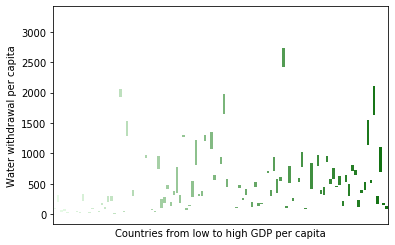

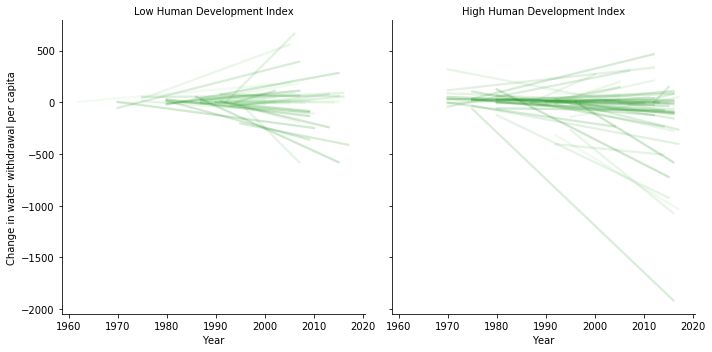

In [12]:
#Procedural way

df_clean = clean(raw_data) 
dfA= modelA_transform(df_clean)
dfB= modelB_transform(dfA)

modelA_fit(dfA)
plt.show()
modelB_fit(dfB)
plt.show()

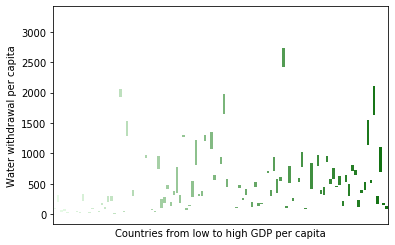

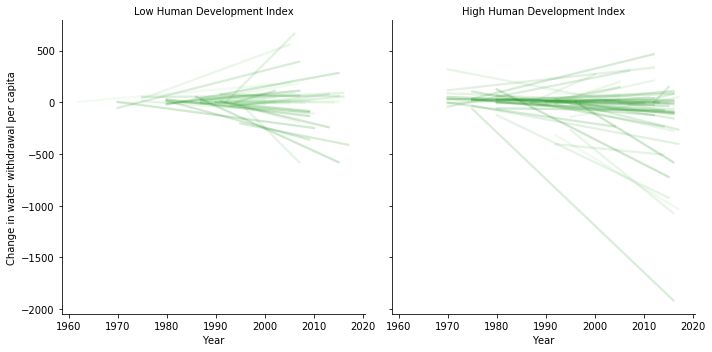

In [13]:
#OOP way

df = DATA(raw_data)

df.modelA()
plt.show()
df.modelB()
plt.show()

In [ ]:
'''What do the graphs show?
The first demonstrates that per-capita GDP is not systematically linked to water withdrawal per capita. 
This is likely because poorer countries use more water for agriculture, while richer countries use more
water for leisure, irrigation, etc.  
The second graph suggests that water withdrawal per capita is dropping faster in countries with a high
Human Development Index.
'''